# Train your DL model using encoded hook data

## Setup

In [ ]:
# First mount your Google drive
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/Thesis/simple-feedforward' # change this if needed

# Imports
import os
import numpy as np
import pickle as pkl
import tensorflow as tf
from tensorflow import keras

Mounted at /content/gdrive


## Load pre-encoded data

In [ ]:
# Load encoded notes and chords
encoded_notes_path = os.path.join(root_path, "encoded_notes.npy")
encoded_chords_path = os.path.join(root_path, "encoded_chords.npy")
encoded_notes = np.load(encoded_notes_path)
encoded_chords = np.load(encoded_chords_path)

# Load song names
song_names_path = os.path.join(root_path, "song_names.pkl")
opened_file = open(song_names_path, "rb")
song_names = pkl.load(opened_file)
opened_file.close()

print(f"Loaded data. Number of 8-bar hooks: {len(song_names)}")

# Input and output vector lengths. For now, chords are input and notes are output
input_length = encoded_chords.shape[1]
output_length = encoded_notes.shape[1]
print(f"Input length: {input_length}")
print(f"Output length: {output_length}")

Loaded data. Number of 8-bar hooks: 3448
Input length: 4096
Output length: 4864


## Define model. First use MiniBach-like architecture, output activation, etc.

In [ ]:
# Let's try dicking around with # of layers, regularization/dropout, and optimizers...

model = keras.Sequential([
    keras.layers.Input(shape=(input_length,)),    
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(output_length, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

## Train model

In [ ]:
model.fit(encoded_chords, encoded_notes, epochs=20)

Epoch 1/20
108/108 [==============================] - 4s 5ms/step - loss: 0.1094 - binary_accuracy: 0.9681
Epoch 2/20
108/108 [==============================] - 1s 5ms/step - loss: 0.0514 - binary_accuracy: 0.9848
Epoch 3/20
108/108 [==============================] - 1s 5ms/step - loss: 0.0507 - binary_accuracy: 0.9849
Epoch 4/20
108/108 [==============================] - 1s 5ms/step - loss: 0.0501 - binary_accuracy: 0.9850
Epoch 5/20
108/108 [==============================] - 1s 5ms/step - loss: 0.0499 - binary_accuracy: 0.9850
Epoch 6/20
108/108 [==============================] - 1s 5ms/step - loss: 0.0495 - binary_accuracy: 0.9850
Epoch 7/20
108/108 [==============================] - 1s 5ms/step - loss: 0.0488 - binary_accuracy: 0.9850
Epoch 8/20
108/108 [==============================] - 0s 5ms/step - loss: 0.0483 - binary_accuracy: 0.9850
Epoch 9/20
108/108 [==============================] - 0s 5ms/step - loss: 0.0481 - binary_accuracy: 0.9850
Epoch 10/20
108/108 [================

## Save model

In [ ]:
model.save('trained_model.h5')

## Test out your model

### Set up Music21 environment

In [ ]:
import music21
from IPython.display import Image, Audio

print("updating apt-get...")
!apt-get update

# enables music21 to render images of musical notes
print("\ninstalling lilypond...")
!apt-get install lilypond > /dev/null

# converts midi files to wav files into order to play them
print("installing fluidsynth...")
!apt-get install fluidsynth > /dev/null
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

print('done!')

!fluidsynth --version
!lilypond --version

updating apt-get...
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [80.8 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 https://de

These helper function will make it easy to show/play Music21 streams within Colab

In [ ]:
# Display the music score
def show(music):
    display(Image(str(music.write('lily.png'))))

# Play the music at a user-specified bpm, or 120 if no bpm specified
def play(music, bpm=120):
    s = music21.stream.Stream()
    s.append(music21.tempo.MetronomeMark(number=bpm))
    s.append(music)
    filename = s.write('mid')
    !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
    display(Audio(filename + '.wav'))

### Set up note translation

In [ ]:
C3_MIDI_VAL = 48
NOTE_ONE_HOT_VECTOR_LENGTH = 38
NUM_16_NOTES_IN_8_BARS = 128

# Given a flattened notes encoding vector, return the one-hot vector at a particular
# timestep (0-indexed, so basically the column number of the 2D representation)
def get_note_one_hot(encoding, timestep):
    start_idx = timestep * NOTE_ONE_HOT_VECTOR_LENGTH
    end_idx = start_idx + NOTE_ONE_HOT_VECTOR_LENGTH
    return encoding[start_idx:end_idx]

# Given a one-hot encoding of a note, return the MIDI value of that note, or 0
# if the note encodes a hold
def decode_note_one_hot(one_hot, is_prediction, force_note=False):
    idx = np.argmax(one_hot)

    # TEMPORARY FIX: filter out some percentage of all holds and choose most likely note instead
    if is_prediction:
        if idx == 0:
            r = np.random.rand()
            thresh = 0.25
            if force_note:
                thresh = 1
            if r < thresh:
                idx = np.argmax(one_hot[1:]) + 1
    # end temporary fix

    ret = 0
    if idx != 0:
        ret = idx + C3_MIDI_VAL - 1
    return ret

# Given an encoding of a melody, return a Music21 stream representing that melody
def translate_notes(encoding, is_prediction=False):
    # Initialize music21 stream
    s = music21.stream.Part()

    # First, move timestep i to the first note in the melody
    i = 0
    while i < NUM_16_NOTES_IN_8_BARS:
        one_hot = get_note_one_hot(encoding, i)
        note_val = decode_note_one_hot(one_hot, is_prediction)
        if note_val != 0:
            break
        else:
            i += 1
        
    # Create a beginning rest note of the appropriate length
    if i > 0:
        rest = music21.note.Rest()
        rest.duration = music21.duration.Duration(i / 4)
        s.append(rest)

    # Add all the notes. timestep i always represents the start of a note, or
    # 1 step past the end of the hook
    while i < NUM_16_NOTES_IN_8_BARS:
        one_hot = get_note_one_hot(encoding, i)
        note_val = decode_note_one_hot(one_hot, is_prediction, force_note=True)

        # Scan for the next note (or to the end of the hook) to determine
        # the note's duration
        j = i + 1
        while j < NUM_16_NOTES_IN_8_BARS:
            one_hot_lookahead = get_note_one_hot(encoding, j)
            note_lookahead = decode_note_one_hot(one_hot_lookahead, is_prediction)
            if note_lookahead != 0:
                break
            else:
                j += 1
        
        # Create the note and add to stream
        note = music21.note.Note(note_val)
        note.duration = music21.duration.Duration((j - i) / 4)
        s.append(note)

        # Move timestep to the next note (or 1 past end of hook)
        i = j

    # Return the stream
    return s

### Set up chord translation

In [ ]:
# Re-create the mapping between chords and one-hot indices

allowed_chords = [
    '00-dim',
    '00-maj',
    '00-min',
    '01-dim',
    '01-maj',
    '02-dim',
    '02-maj',
    '02-min',
    '03-dim',
    '03-maj',
    '03-min',
    '04-dim',
    '04-maj',
    '04-min',
    '05-maj',
    '05-min',
    '06-dim',
    '06-maj',
    '07-dim',
    '07-maj',
    '07-min',
    '08-dim',
    '08-maj',
    '09-dim',
    '09-maj',
    '09-min',
    '10-maj',
    '10-min',
    '11-dim',
    '11-maj',
    '11-min'
]

def create_converted_chord_to_idx_map():
    map = []
    start_idx = 1 # start at 1 since idx 0 is reserved for holds
    for chord_str in allowed_chords:
        map.append([chord_str, start_idx])
        start_idx += 1
    return map

converted_chord_to_idx_map = create_converted_chord_to_idx_map()
for item in converted_chord_to_idx_map:
    print(item)

['00-dim', 1]
['00-maj', 2]
['00-min', 3]
['01-dim', 4]
['01-maj', 5]
['02-dim', 6]
['02-maj', 7]
['02-min', 8]
['03-dim', 9]
['03-maj', 10]
['03-min', 11]
['04-dim', 12]
['04-maj', 13]
['04-min', 14]
['05-maj', 15]
['05-min', 16]
['06-dim', 17]
['06-maj', 18]
['07-dim', 19]
['07-maj', 20]
['07-min', 21]
['08-dim', 22]
['08-maj', 23]
['09-dim', 24]
['09-maj', 25]
['09-min', 26]
['10-maj', 27]
['10-min', 28]
['11-dim', 29]
['11-maj', 30]
['11-min', 31]


In [ ]:
C2_MIDI_VAL = 36
CHORD_ONE_HOT_VECTOR_LENGTH = 32

# Given a flattened chord encoding vector, return the one-hot vector at a particular
# timestep (0-indexed, so basically the column number of the 2D representation)
def get_chord_one_hot(encoding, timestep):
    start_idx = timestep * CHORD_ONE_HOT_VECTOR_LENGTH
    end_idx = start_idx + CHORD_ONE_HOT_VECTOR_LENGTH
    return encoding[start_idx:end_idx]

# Given the string form of a chord (like '00-maj'), return the [semi, chord_class]
# form
def str_to_converted_chord(str_form):
    semi = int(str_form[0:2])
    chord_class = str_form[3:6]
    return [semi, chord_class]

# Given a one-hot encoding of a chord, return the [semitone, class] form of the
# chord, or 0 if the encoding denotes a hold
def decode_chord_one_hot(one_hot):
    idx = np.argmax(one_hot)
    if idx == 0:
        return 0

    str_form = ''
    map_lookup_successful = False
    for item in converted_chord_to_idx_map:
        if item[1] == idx:
            str_form = item[0]
            map_lookup_successful = True
            break

    if not map_lookup_successful:
        raise Exception("Error when converting one-hot idx to str_form!")
    else:
        return str_to_converted_chord(str_form)

# Given a chord in the form [semitone, class], return a list of the 3 MIDI
# notes comprising the triad. All chords in open-form
def chord_to_MIDI_list(chord):
    semi = chord[0]
    chord_class = chord[1]

    low = chord[0] + C2_MIDI_VAL
    mid = low + 7
    if chord_class == 'dim':
        mid -= 1
    hi = low + 16
    if chord_class == 'dim' or chord_class == 'min':
        hi -= 1
    
    return [low, mid, hi]


# Given an encoding of a chord sequence, return a Music21 stream representing
# that chord sequence
def translate_chords(encoding):
    # Initialize music21 stream
    s = music21.stream.Part()
    s.append(music21.clef.BassClef())

    # First, move timestep i to the first chord in the sequence
    i = 0
    while i < NUM_16_NOTES_IN_8_BARS:
        one_hot = get_chord_one_hot(encoding, i)
        chord_item = decode_chord_one_hot(one_hot)
        if chord_item != 0:
            break
        else:
            i += 1
        
    # Create a beginning rest of the appropriate length
    if i > 0:
        rest = music21.note.Rest()
        rest.duration = music21.duration.Duration(i / 4.0)
        s.append(rest)

    # Add all the chords. timestep i always represents the start of a chord, or
    # 1 step past the end of the hook
    while i < NUM_16_NOTES_IN_8_BARS:
        one_hot = get_chord_one_hot(encoding, i)
        chord_item = decode_chord_one_hot(one_hot)

        # Scan for the next chord (or to the end of the hook) to determine
        # the chord's duration
        j = i + 1
        while j < NUM_16_NOTES_IN_8_BARS:
            one_hot_lookahead = get_chord_one_hot(encoding, j)
            chord_lookahead = decode_chord_one_hot(one_hot_lookahead)
            if chord_lookahead != 0:
                break
            else:
                j += 1
        
        # Create the chord and add to stream
        notes_in_chord = chord_to_MIDI_list(chord_item)
        chord = music21.chord.Chord(notes_in_chord)
        chord.duration = music21.duration.Duration((j - i) / 4.0)
        s.append(chord)

        # Move timestep to the next note (or 1 past end of hook)
        i = j

    # Return the stream
    return s

In [ ]:
# Given a notes stream and chords stream, create a 2-part stream
def combine_streams(notes_stream, chords_stream):
    master_score = music21.stream.Score()
    master_score.append(notes_stream)
    master_score.append(chords_stream)
    master_score[1].offset = 0.0
    return master_score


### Try to predict the melody for "Hey Soul Sister" using your trained model

In [ ]:
HEY_SOUL_SISTER_IDX = 414

def predict_given_idx(idx):
    # Make prediction
    chords = encoded_chords[idx]
    predicted_notes = model.predict(chords.reshape(1, -1))
    predicted_notes = predicted_notes.reshape(-1)

    # Generate Music21 stream
    notes_stream = translate_notes(predicted_notes, is_prediction=True)
    chords_stream = translate_chords(chords)
    master_score = combine_streams(notes_stream, chords_stream)

    show(master_score)
    play(master_score)

def show_actual_given_idx(idx):
    notes = encoded_notes[idx]
    chords = encoded_chords[idx]
    notes_stream = translate_notes(notes)
    chords_stream = translate_chords(chords)
    master_score = combine_streams(notes_stream, chords_stream)

    show(master_score)
    play(master_score)


print("Generated melody for Hey Soul Sister")
predict_given_idx(HEY_SOUL_SISTER_IDX)
print("This is the actual melody for Hey Soul Sister")
show_actual_given_idx(HEY_SOUL_SISTER_IDX)

Output hidden; open in https://colab.research.google.com to view.

### Check a minor-key song (LoveGame by Lady Gaga)

In [ ]:
LOVEGAME_IDX = 300

print(f"Generated melody for {song_names[LOVEGAME_IDX]}:")
predict_given_idx(LOVEGAME_IDX)
print(f"Actual melody for {song_names[LOVEGAME_IDX]}:")
show_actual_given_idx(LOVEGAME_IDX)

Output hidden; open in https://colab.research.google.com to view.

## Display a schematic of your model

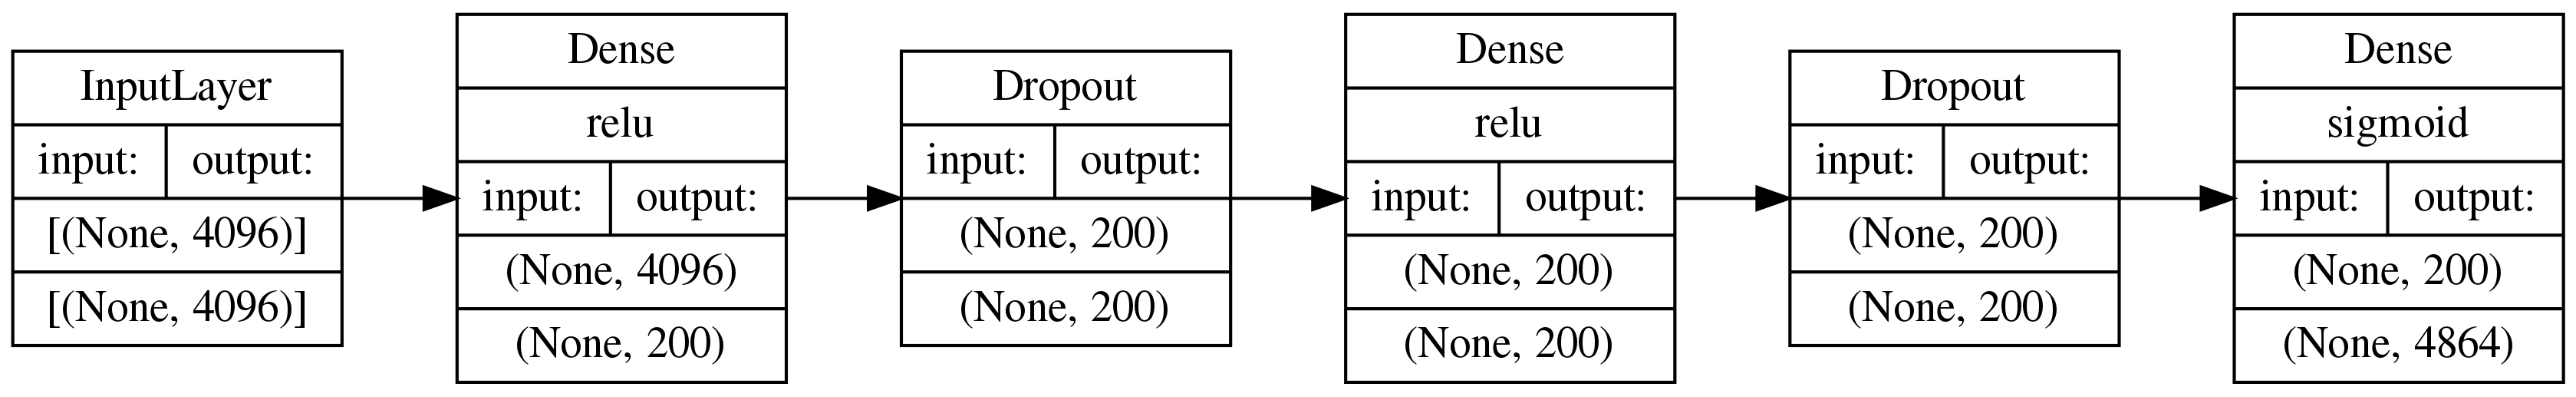

In [23]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False, rankdir="LR", dpi=300, show_layer_activations=True)